In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns; sns.set()
import statsmodels.api as sm

from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"
TABLE_NAME = "res_tickers_history"

warnings.filterwarnings("ignore")

In [2]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_by_month`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df



def test_p_value(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')


def stationarity_test(data):
    test_p_value(data['volume_weighted_average_price'])


def plot_history(data):
    plt.figure(figsize=(20, 10), dpi=150)
    plt.plot(data.date, data.volume_weighted_average_price, color='tab:blue')
    plt.gca().set(title=f'{data.name} Stock History', xlabel='Date', ylabel='$')
    plt.show()

def plot_trend(data):
    data['volume_weighted_average_price'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
    data['volume_weighted_average_price'].rolling(12).std().plot(label='12 STD')
    data['volume_weighted_average_price'].plot()
    plt.legend()


def seasonal_decomposition(data):
    result_add = seasonal_decompose(data.volume_weighted_average_price, model='additive', extrapolate_trend='freq', period=12)
    plt.rcParams.update({'figure.figsize': (20, 20)})
    result_add.plot().suptitle('', fontsize=15)
    plt.show()


def arima_model_selector(data, pdq, seasonal_pdq):
    models = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    data.volume_weighted_average_price,
                    order=param, seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
                results = mod.fit(disp=False)
                models.append((param, param_seasonal, results.aic))
                #print('SARIMA{}*{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return models


def acf_pacf(data):
    data['first_diff']=data['volume_weighted_average_price'] - data['volume_weighted_average_price'].shift(1)
    data['second_diff'] = data['first_diff'] - data['first_diff'].shift(1)
    data['seasonal_diff'] = data['volume_weighted_average_price'] - data['volume_weighted_average_price'].shift(12)
    test_p_value(data['first_diff'].dropna())
    test_p_value(data['second_diff'].dropna())
    test_p_value(data['seasonal_diff'].dropna())
    first_diff = plot_acf(data['first_diff'].dropna())
    sec_diff = plot_pacf(data['second_diff'].dropna())


def run_best_model(data, model, months):
    model = sm.tsa.statespace.SARIMAX(
        data.volume_weighted_average_price,
        order=model[0], seasonal_order=model[1],
        enforce_stationarity=False,
        enforce_invertibility=False)
    results = model.fit(disp=False)
    data['prediction'] = results.predict()
    data[['volume_weighted_average_price', 'prediction']].plot(figsize=(12,8))
    extra_dates = [data.set_index('date').index[-1] + DateOffset(months=m) for m in range (1, months)]
    forecast_df = pd.DataFrame(index=extra_dates, columns=data.columns)
    data = data.set_index(pd.DatetimeIndex(data['date']))
    combined_df = pd.concat([data, forecast_df]).reset_index()
    combined_df['prediction'] = results.predict(len(amazon), len(combined_df))
    combined_df[['date','volume_weighted_average_price','prediction']].plot(figsize=(12,6))
    return combined_df

In [3]:
apple = query_ticker_data('AAPL')
netflix = query_ticker_data('NFLX')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_by_month` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard")
fb = query_ticker_data('FB')
microsoft = query_ticker_data('MSFT')
amazon = query_ticker_data('AMZN')
alphabet = query_ticker_data('GOOGL')
coke = query_ticker_data('KO')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

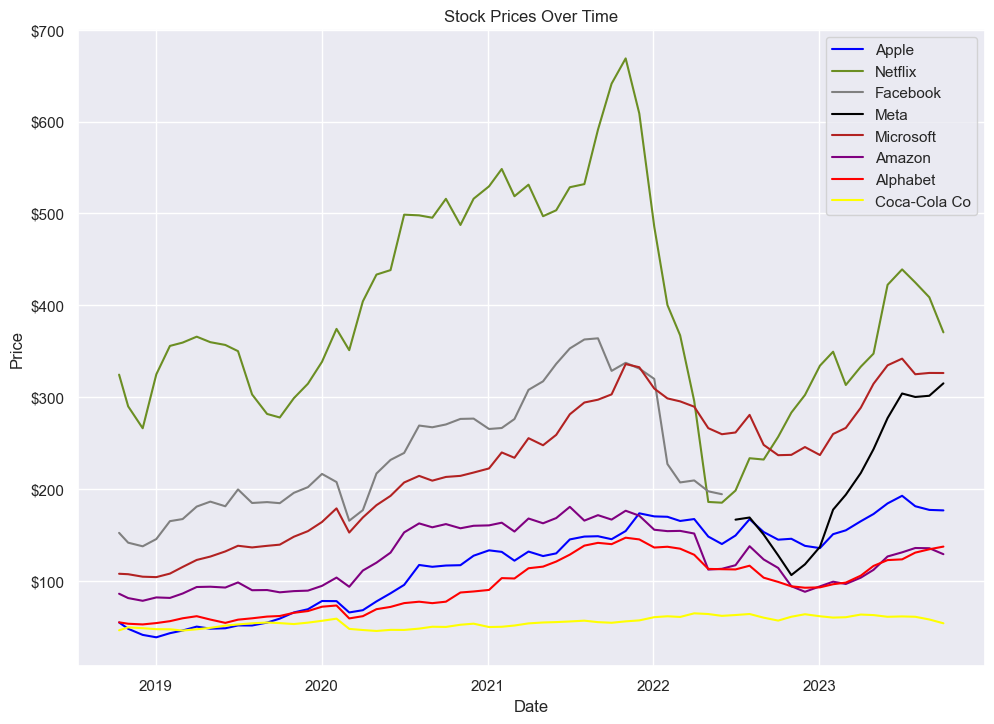

In [4]:
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

company = [apple, netflix, fb, meta, microsoft, amazon, alphabet, coke]
color = ['blue', 'olivedrab', 'grey','black','firebrick','purple', 'red', 'yellow']    
for cmp, clr in zip(company,color):
    ax = sns.lineplot(data=cmp,x="date",y="volume_weighted_average_price",color=clr,label=cmp.name)
    ax.set(xlabel='Date',
       ylabel='Price',
       title='Stock Prices Over Time')
    ticks = ax.get_yticks()
    # formatted the values into strings beginning with dollar sign
    new_labels = [f'${int(amt)}' for amt in ticks]
    # Set the new labels
    ax.set_yticklabels(new_labels)    

plt.show()

In [5]:
TARGET_DF = microsoft

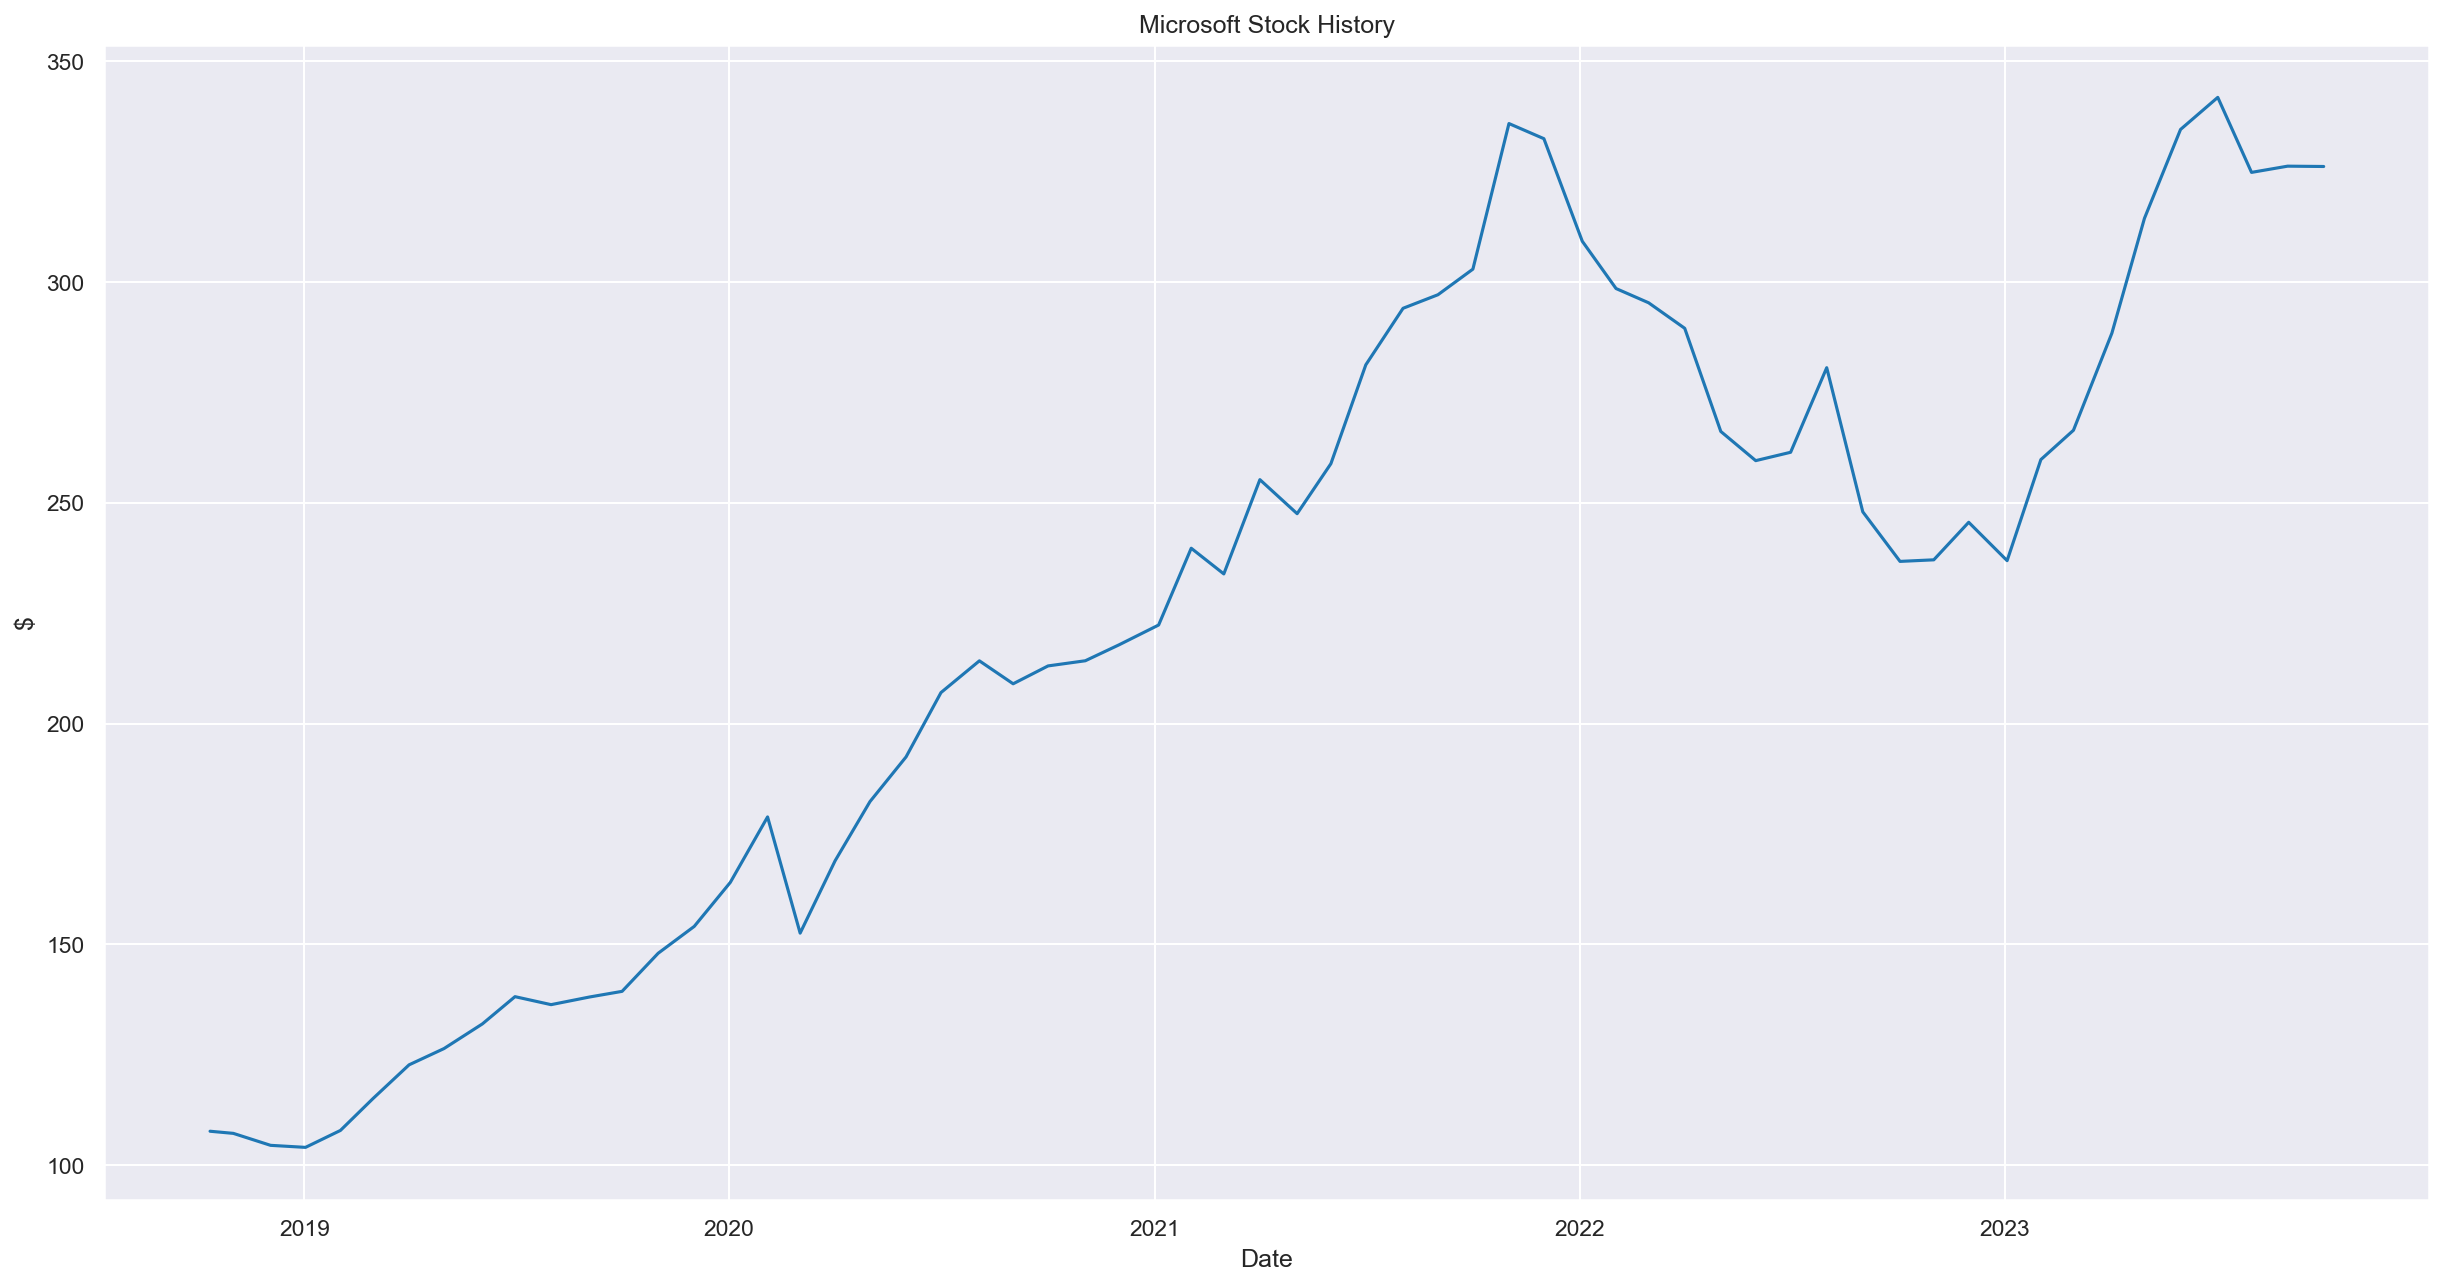

In [6]:
plot_history(TARGET_DF)

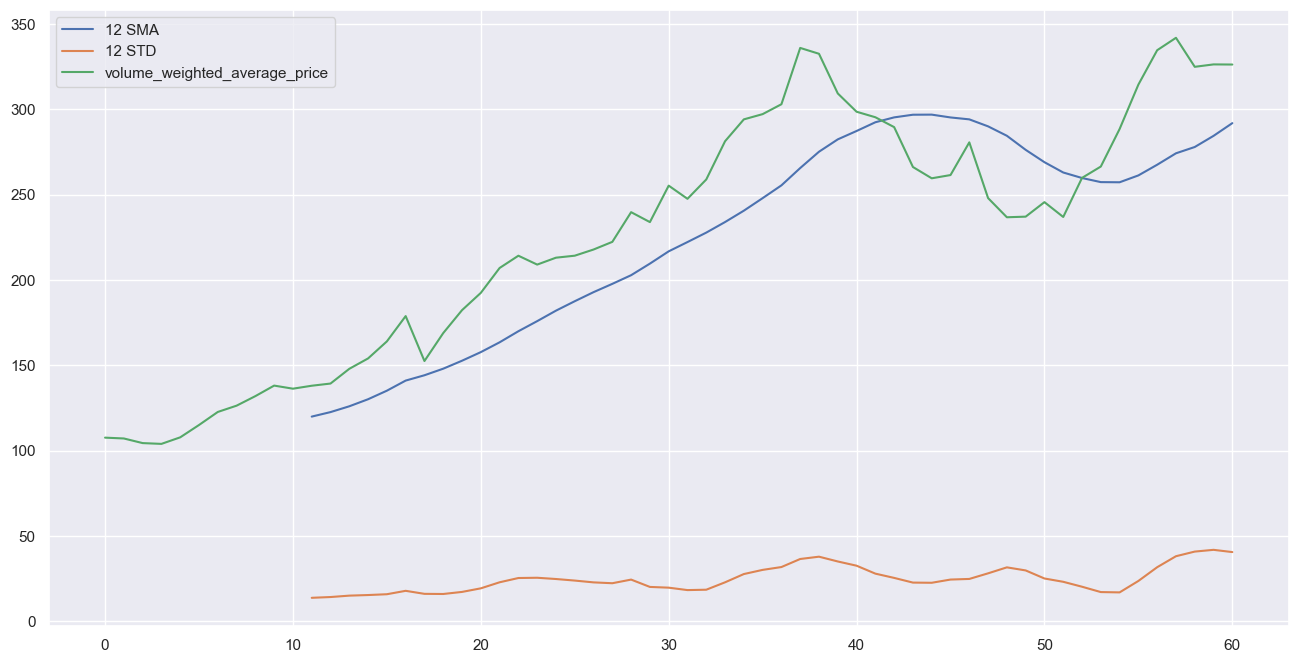

In [7]:
plot_trend(TARGET_DF)

In [8]:
stationarity_test(TARGET_DF)

P-value:  0.7733864497758267
Do not reject null hypothesis, data is not stationary


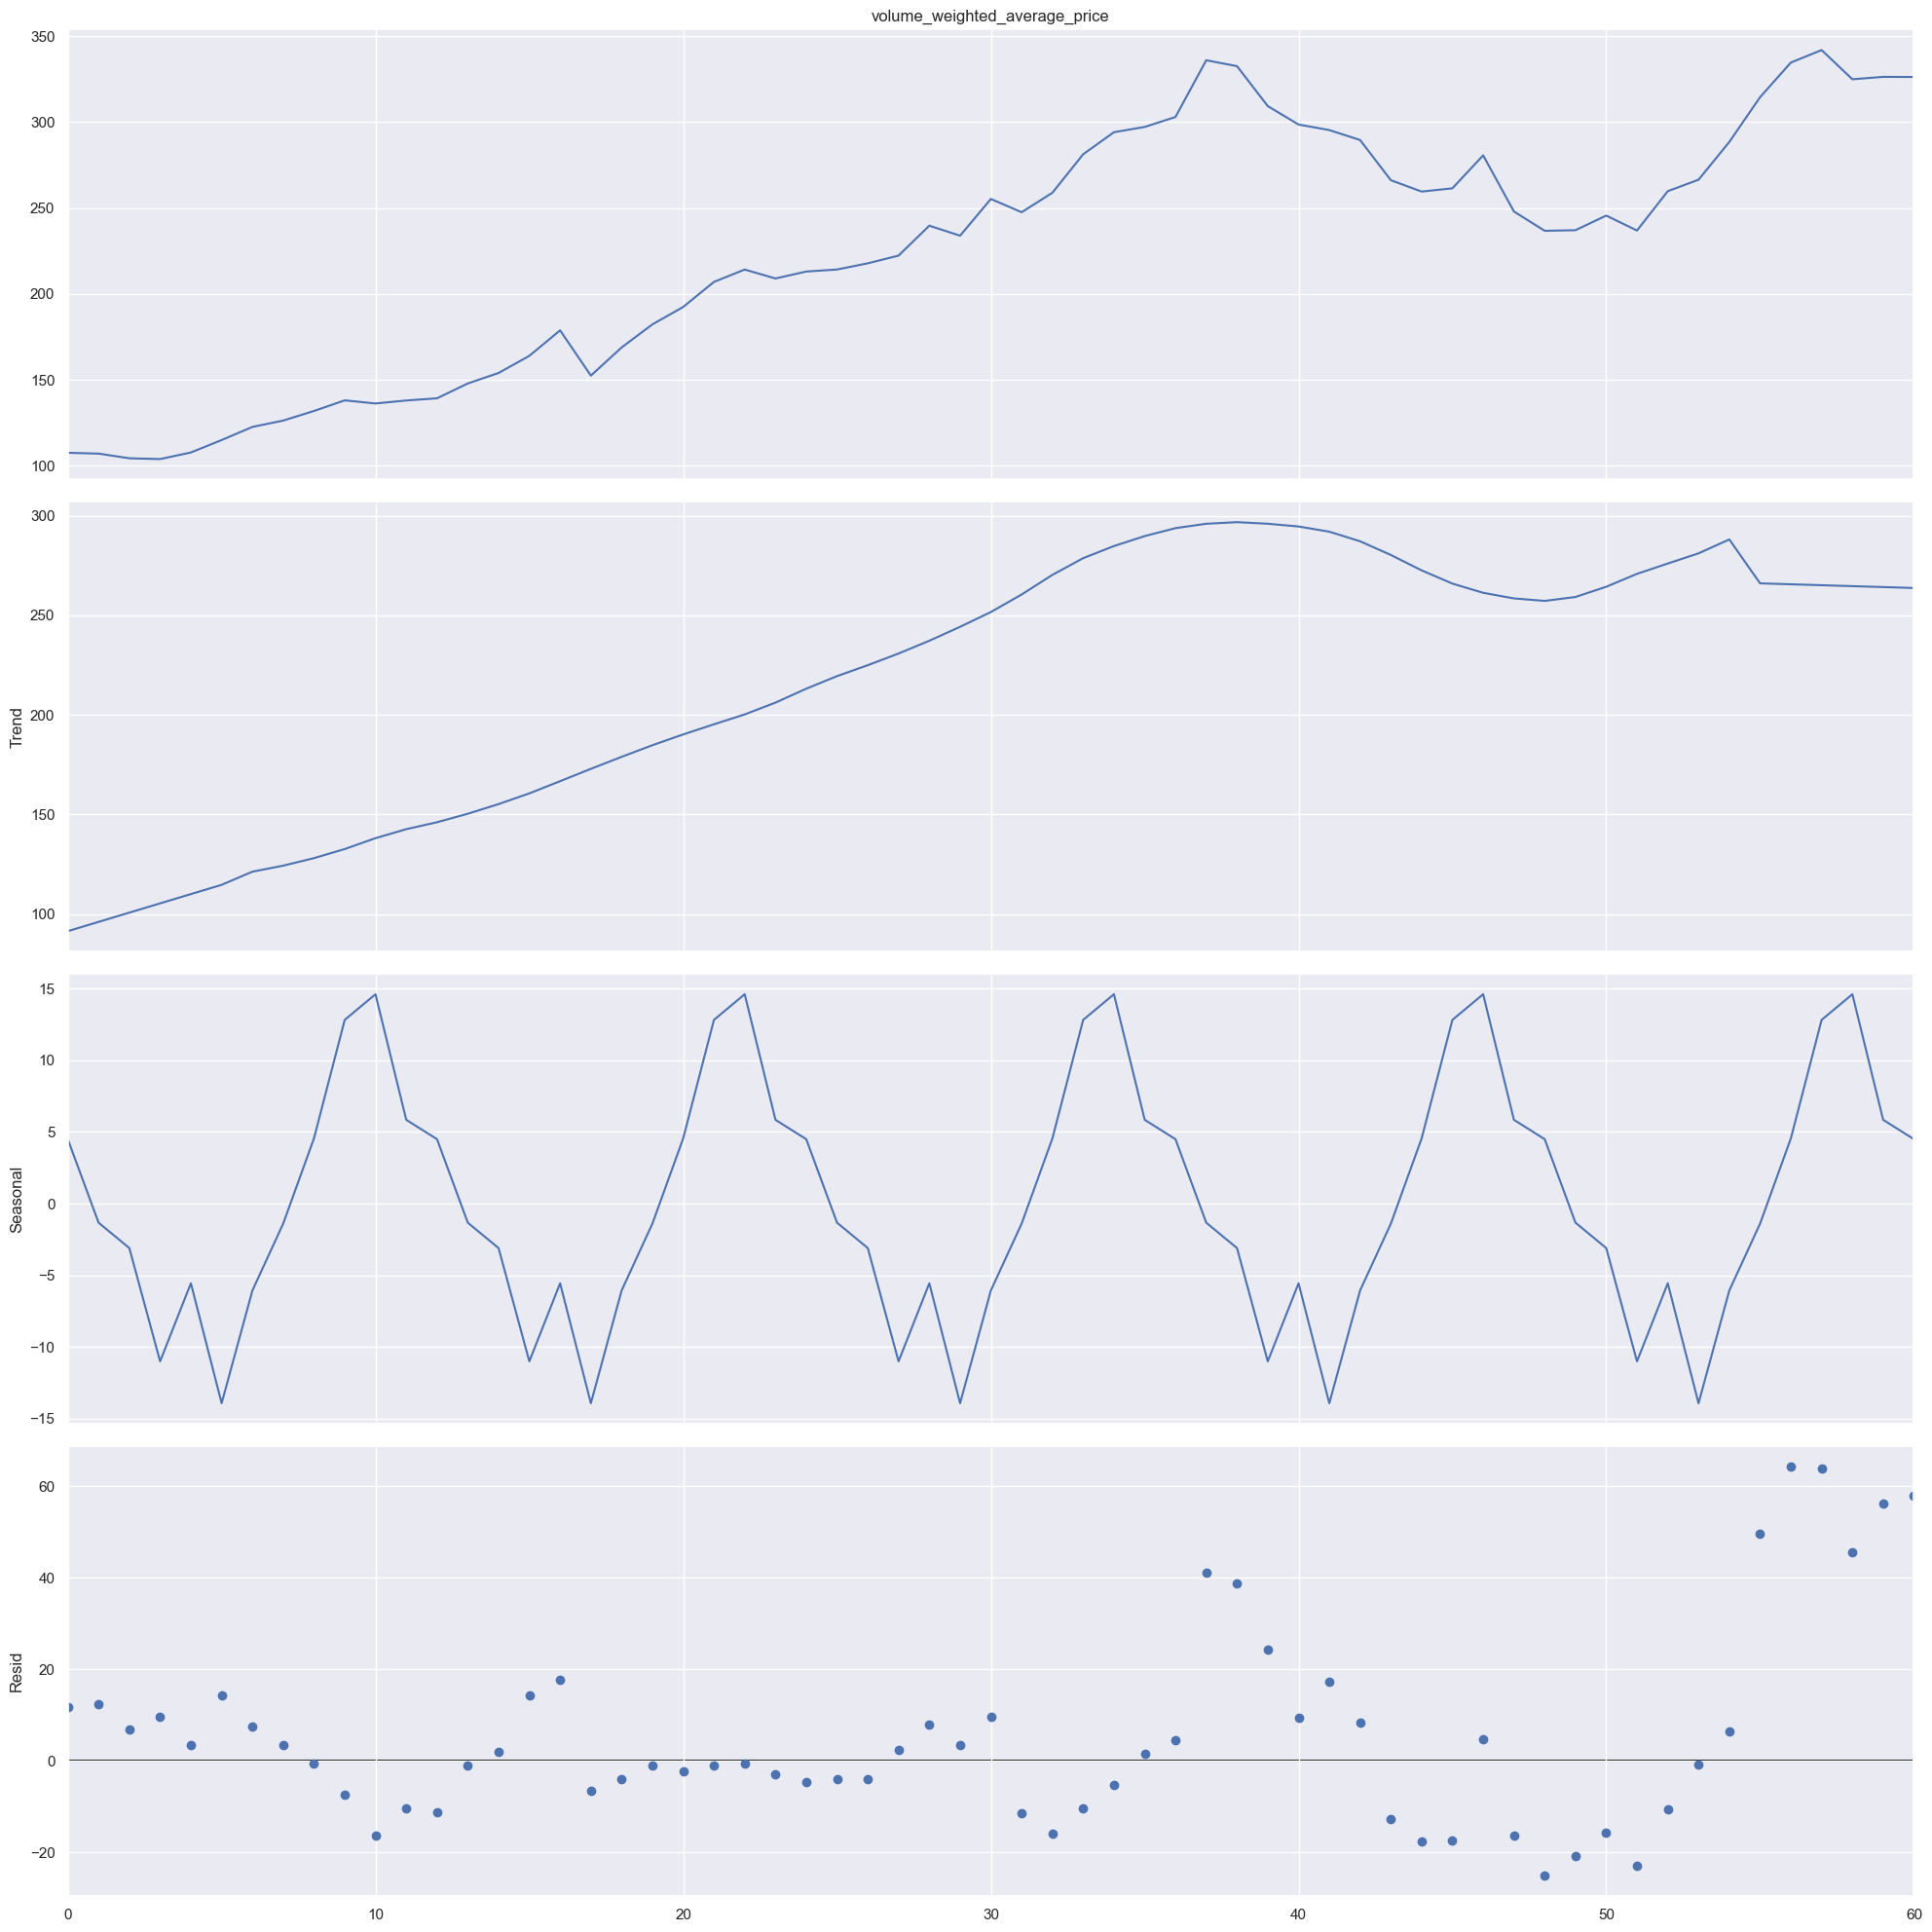

In [9]:
seasonal_decomposition(TARGET_DF)

P-value:  4.6861196823624164e-09
Reject null hypothesis, data is stationary
P-value:  2.5562376786358674e-12
Reject null hypothesis, data is stationary
P-value:  0.04760382326020885
Reject null hypothesis, data is stationary


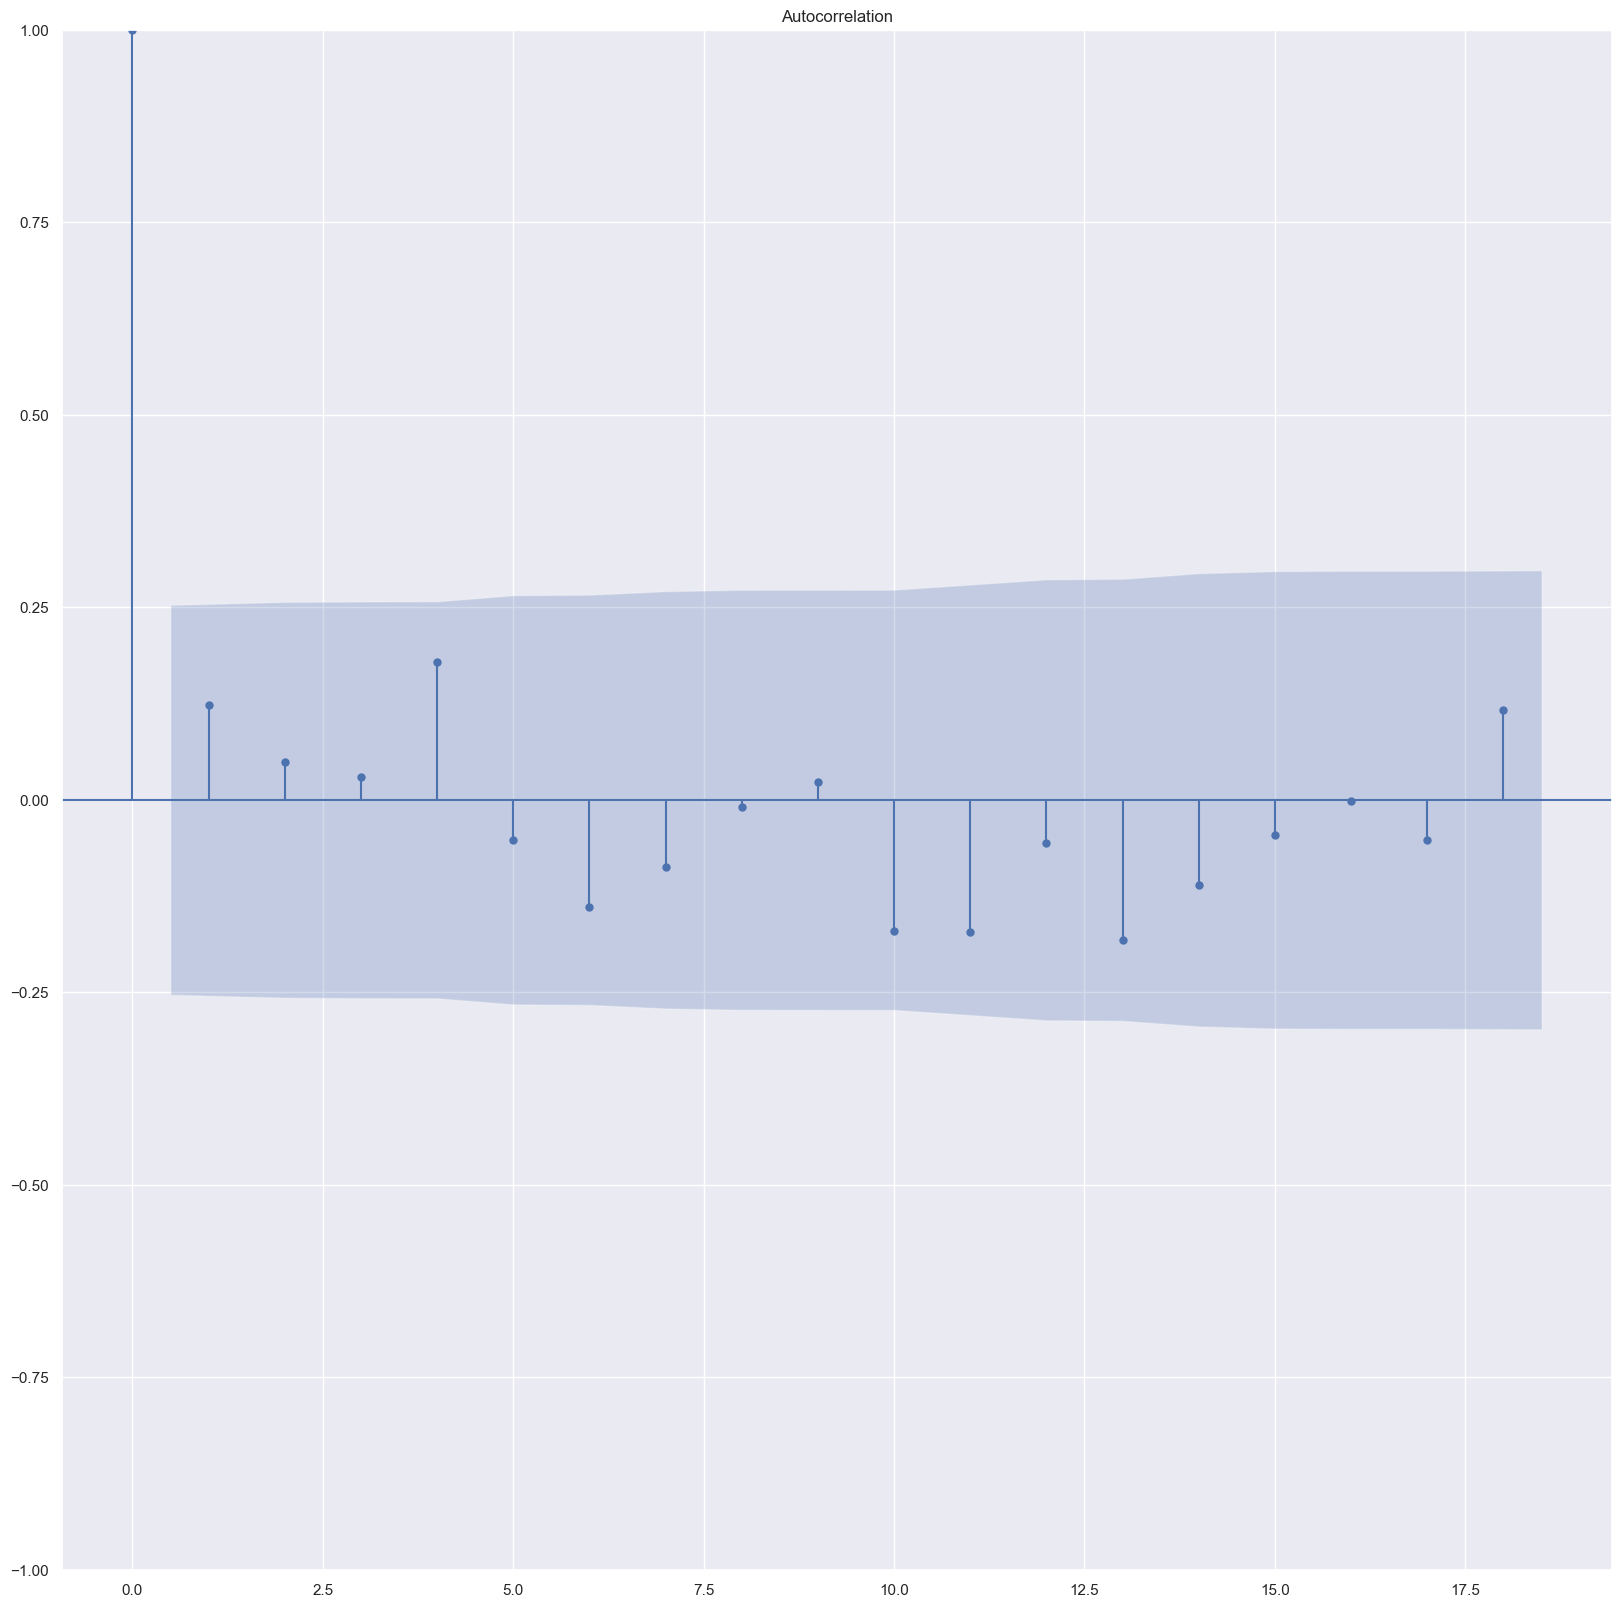

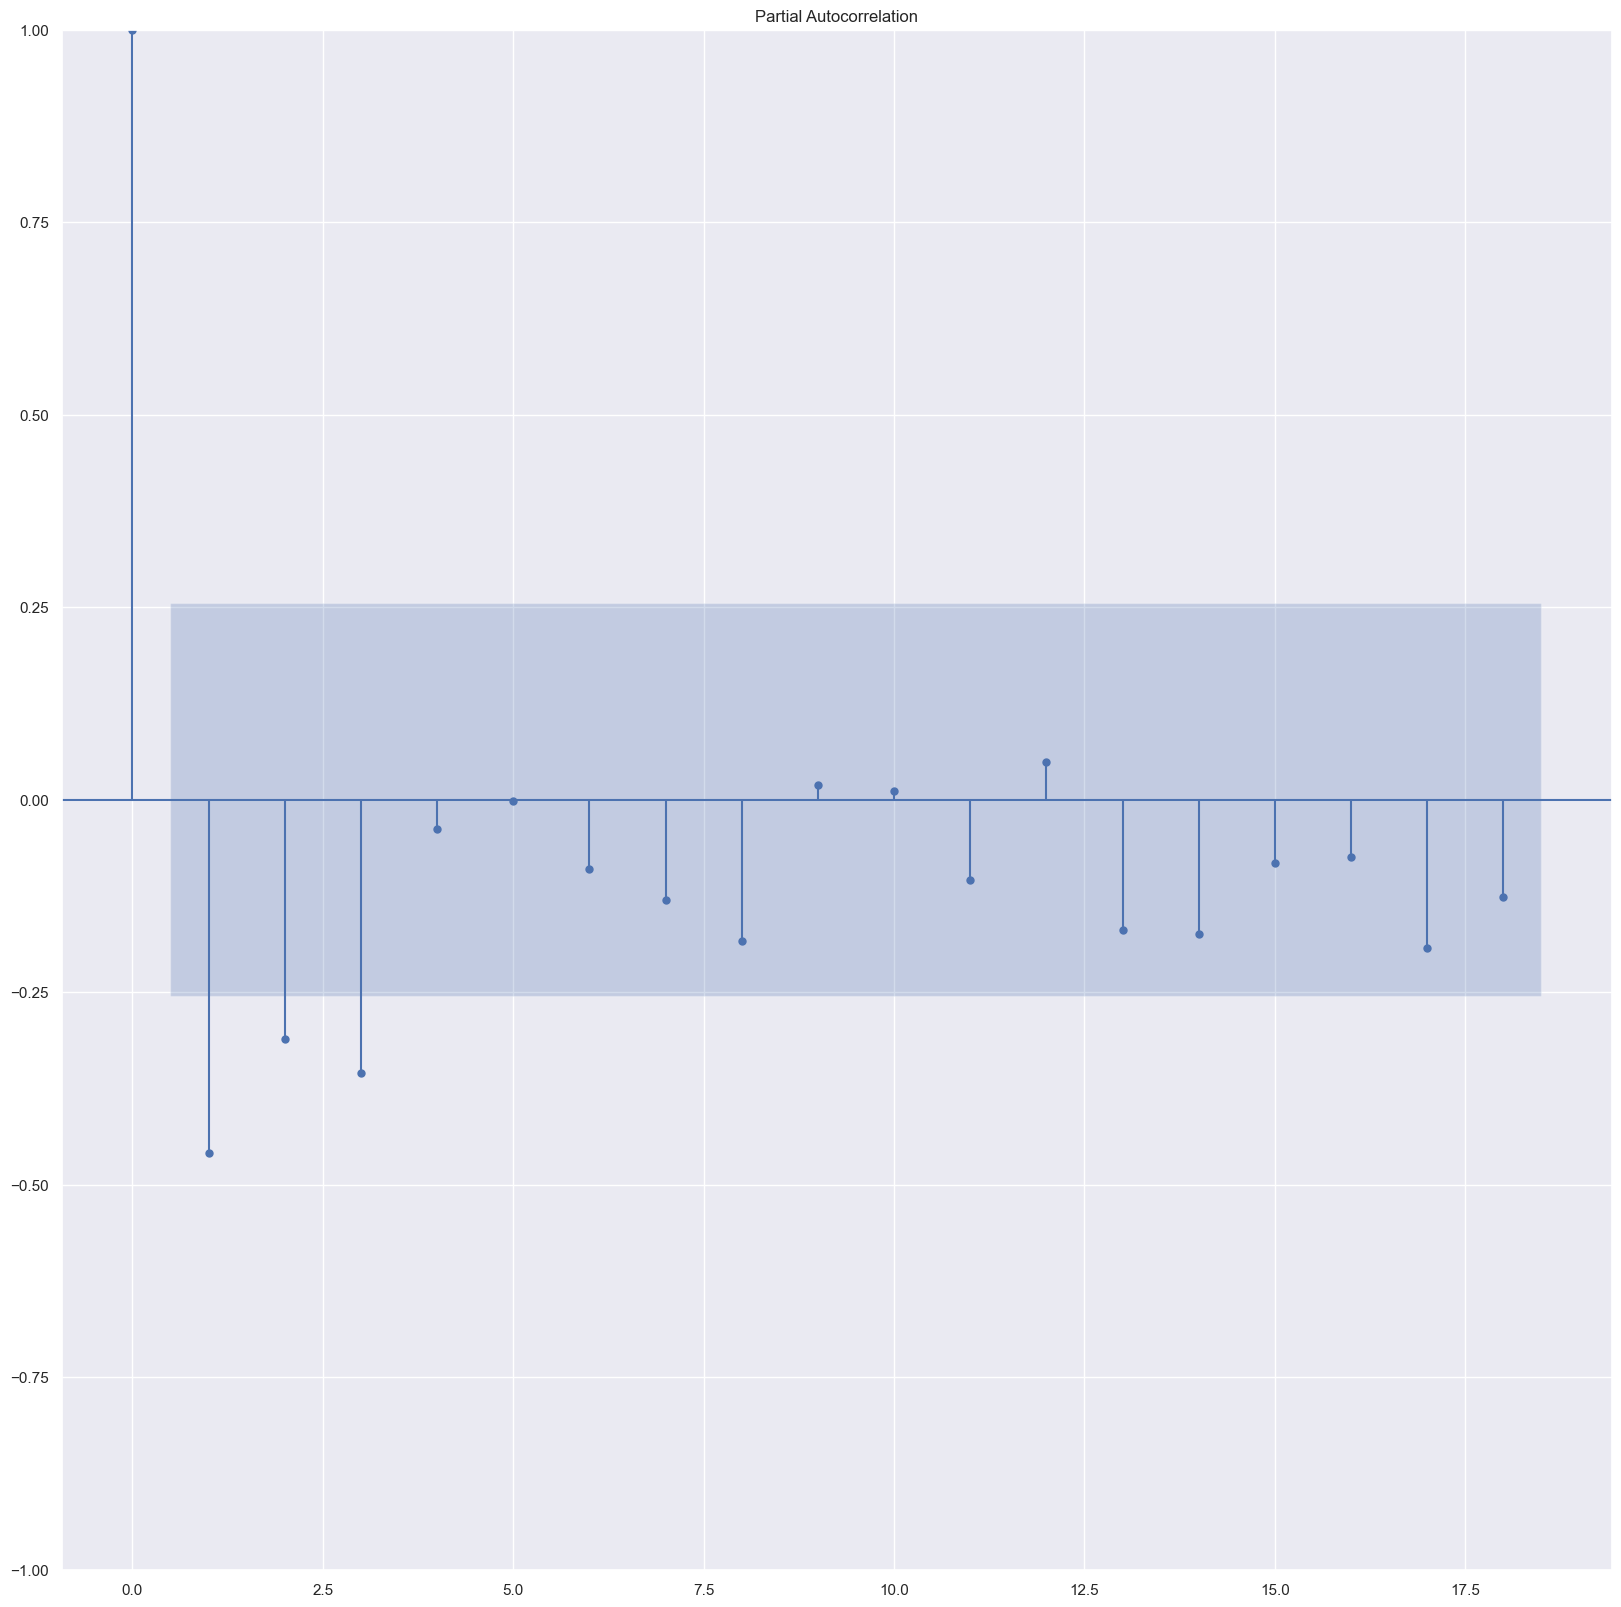

In [10]:
acf_pacf(TARGET_DF)

In [11]:
#p = range(0, 3)
#d = range(0, 6)
#q = range(0, 3)
p = d = q = range(0, 2)
#generate patterns from p,q,r
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [12]:
models = arima_model_selector(TARGET_DF, pdq, seasonal_pdq)

In [13]:
model_params = pd.DataFrame(models, columns=["param", "param_seasonal", "aic"])

In [14]:
best_model = model_params[model_params['aic']==model_params['aic'].min()].values.tolist()[0]

In [15]:
best_model

[(1, 0, 1), (0, 1, 1, 12), 297.4400415742573]

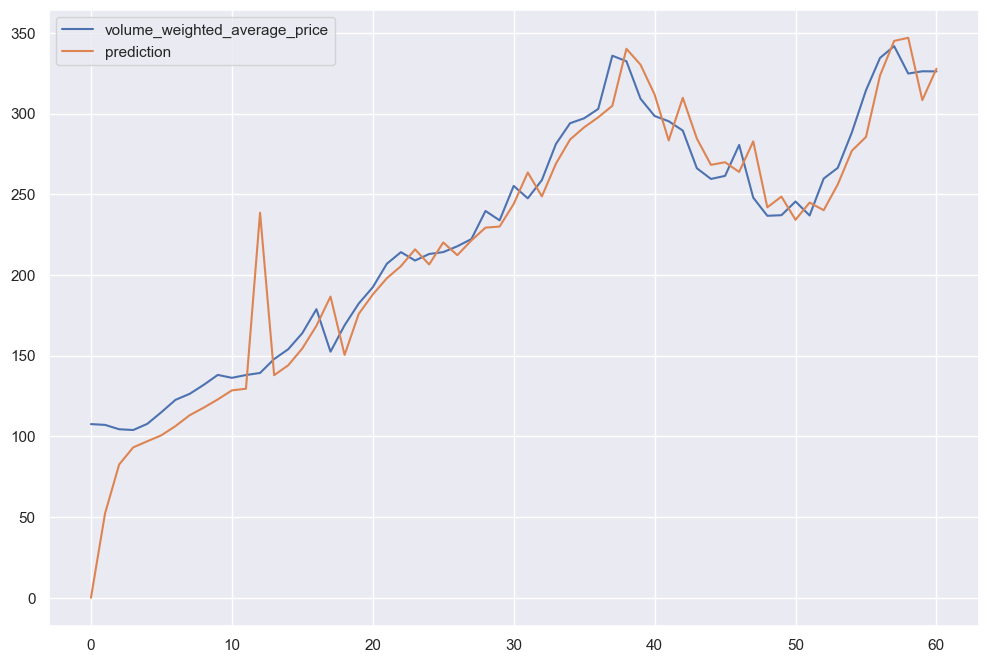

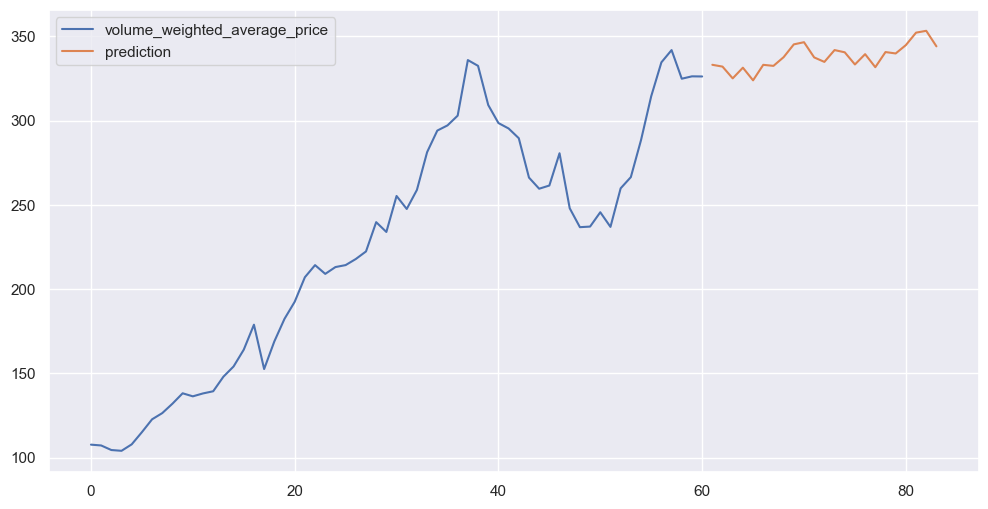

In [16]:
y = run_best_model(TARGET_DF, best_model, 24)